# **WEEK 2 Analysis**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit


plt.style.use("seaborn-v0_8")


**For this week's analysis, I will use AAPL asset.**

In [4]:
apple_data = yf.download('AAPL' , start = '2015-01-01', end = '2025-01-01',auto_adjust=False)

[*********************100%***********************]  1 of 1 completed




FEATURE CONSTRUCTION

In [5]:
apple_price = apple_data['Adj Close']
feature = pd.DataFrame()
feature['r_t'] = np.log(apple_data['Adj Close']/apple_data['Adj Close'].shift(1))
feature['r_t-1'] = feature.r_t.shift(1)
feature['20-day_rolling_mean'] = apple_price.rolling(window=20).mean()
feature['20-day_rolling_volatility'] = feature['r_t'].rolling(window=20).std()
feature['5-day_momentum'] = feature['r_t'].rolling(window=5).mean()

## **NAIVE BASELINES**

1. ZERO PREDICTOR

In [6]:
# I'll add a series to the features dataframe. 
feature['zero_predictor'] = 0

2. Rolling mean predictor - 5-day mean of returns

In [7]:
# stored the mean of last 5 days' returns. 
prev_momentum = feature['5-day_momentum'].shift(1)
feature['rolling_mean_predictor'] = prev_momentum

## **Linear Models(OLS and Ridge)** 

1. OLS - We here assume that the market follows a linear relationship with time.
2. Ridge

In [8]:
#to use fit function of sklearn, we need to get rid of rows, which have NaN in them. 
feature = feature.dropna()

# in the first argument  x, we will have lagged returns, momentum, volatility
x = feature[['r_t-1', '5-day_momentum', '20-day_rolling_volatility']]

# in the 2nd argument, we want to have the original returns of the day, it helps the algo to get weights so the predicted return is as close as possible.
y = feature['r_t']

ols_model = LinearRegression().fit(x,y)
feature['ols_prediction'] = ols_model.predict(x)

#Applying ridge model
ridge_model = Ridge().fit(x,y)
feature['ridge_prediction'] = ridge_model.predict(x)

feature.head(5)

,r_t,r_t-1,20-day_rolling_mean,20-day_rolling_volatility,5-day_momentum,zero_predictor,rolling_mean_predictor,ols_prediction,ridge_prediction
Date,,,,,,,,,
2015-02-02,0.012469,-0.014743,24.631385,0.023655,0.009547,0,0.007266,0.017184,0.002643
2015-02-03,0.000168,0.012469,24.768834,0.022407,0.016709,0,0.009547,0.018703,0.002509
2015-02-04,0.007640,0.000168,24.916259,0.022374,0.007239,0,0.016709,0.009764,0.001752
2015-02-05,0.007112,0.007640,25.056627,0.022298,0.002530,0,0.007239,0.001388,0.000839
2015-02-06,-0.008457,0.007112,25.139866,0.021155,0.003787,0,0.002530,0.003141,0.001027


## **Time Series Split Evaluation**

# **Prediction accuracy**
I will use RMSE values of 5 days and 21 days(approx one month of stock market) for every model.

In [13]:
#RMSE of zero returns -- dont use RMSE function here, cuz vo dono columns ko minus karega and unka ek value nikal dega. one single value for two columns...
#for 5 days
feature['RMSE_zero_pred_5days'] = np.sqrt(((feature['r_t'] - feature['zero_predictor'])**2).rolling(window = 5).mean())
feature['RMSE_rolling_pred_5days'] = np.sqrt(((feature['r_t'] - feature['rolling_mean_predictor'])**2).rolling(window = 5).mean())
feature['RMSE_ols_pred_5days'] = np.sqrt(((feature['r_t'] - feature['ols_prediction'])**2).rolling(window = 5).mean())
feature['RMSE_ridge_pred_5days'] = np.sqrt(((feature['r_t'] - feature['ridge_prediction'])**2).rolling(window = 5).mean())

#for 21 days
feature['RMSE_zero_pred_21days'] = np.sqrt(((feature['r_t'] - feature['zero_predictor'])**2).rolling(window = 21).mean())
feature['RMSE_rolling_pred_21days'] = np.sqrt(((feature['r_t'] - feature['rolling_mean_predictor'])**2).rolling(window = 21).mean())
feature['RMSE_ols_pred_21days'] = np.sqrt(((feature['r_t'] - feature['ols_prediction'])**2).rolling(window = 21).mean())
feature['RMSE_ridge_pred_21days'] = np.sqrt(((feature['r_t'] - feature['ridge_prediction'])**2).rolling(window = 21).mean())



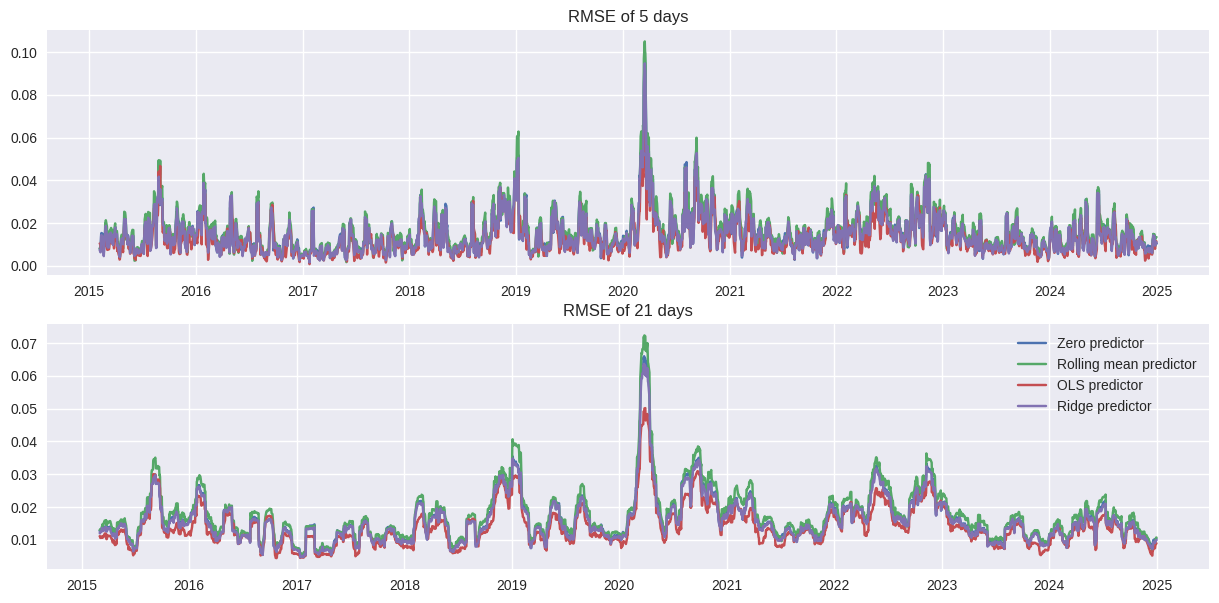

In [23]:
plt.figure(figsize=(15,7))
plt.subplot(2,1,1)
plt.plot(feature['RMSE_zero_pred_5days'], label = 'Zero predictor')
plt.plot(feature['RMSE_rolling_pred_5days'], label = 'Rolling mean predictor')
plt.plot(feature['RMSE_ols_pred_5days'], label = 'OLS predictor')
plt.plot(feature['RMSE_ridge_pred_5days'], label = 'Ridge predictor')
plt.title('RMSE of 5 days')


plt.subplot(2,1,2)
plt.plot(feature['RMSE_zero_pred_21days'], label = 'Zero predictor')
plt.plot(feature['RMSE_rolling_pred_21days'], label = 'Rolling mean predictor')
plt.plot(feature['RMSE_ols_pred_21days'], label = 'OLS predictor')
plt.plot(feature['RMSE_ridge_pred_21days'], label = 'Ridge predictor')
plt.title('RMSE of 21 days')

plt.legend()
plt.show()

Volatility scaled/normalised prediction error.

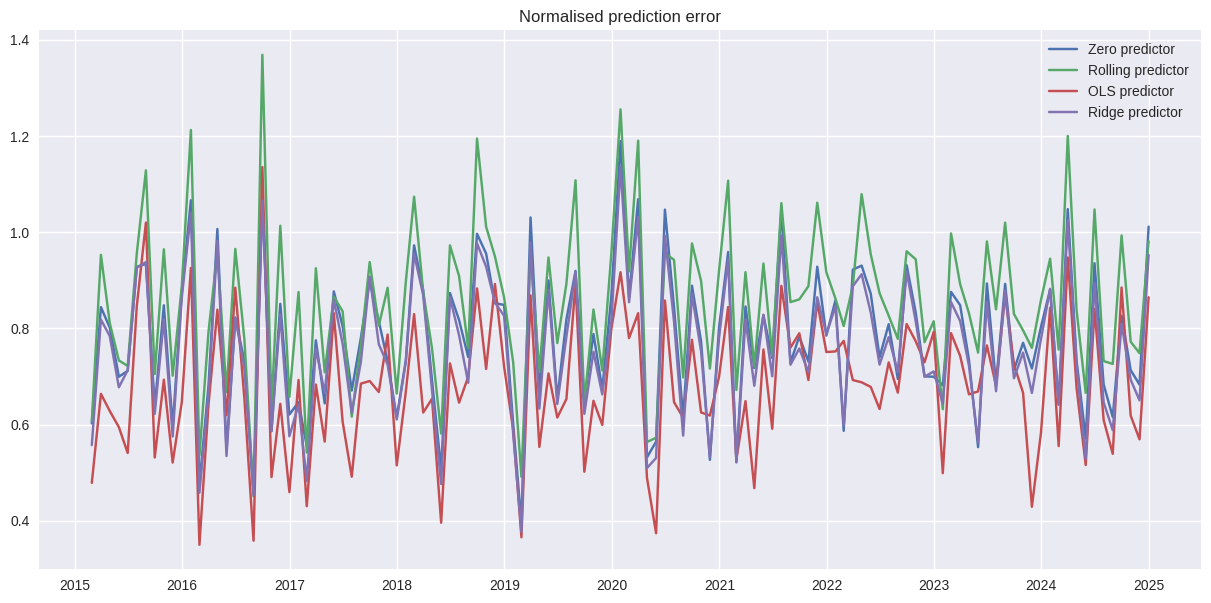

In [ ]:

#Calculated normalised error, by dividing the difference of predicted and actual value, dividing by volatility.
feature['normalised_zero_error'] = (feature['r_t'] - feature['zero_predictor']).abs()/feature['20-day_rolling_volatility']
feature['normalised_rolling_error'] = (feature['r_t'] - feature['rolling_mean_predictor']).abs()/feature['20-day_rolling_volatility']
feature['normalised_ols_error'] = (feature['r_t'] - feature['ols_prediction']).abs()/feature['20-day_rolling_volatility']
feature['normalised_ridge_error'] = (feature['r_t'] - feature['ridge_prediction']).abs()/feature['20-day_rolling_volatility']


#The graph would be full of noise, so we averaged it monthly to reduce noise. 
plt.figure(figsize=(15,7))
plt.plot(feature['normalised_zero_error'].resample('ME').mean(), label = 'Zero predictor')
plt.plot(feature['normalised_rolling_error'].resample('ME').mean(), label = 'Rolling predictor')
plt.plot(feature['normalised_ols_error'].resample('ME').mean(), label = 'OLS predictor')
plt.plot(feature['normalised_ridge_error'].resample('ME').mean(), label = 'Ridge predictor')

plt.title('Normalised prediction error')
plt.legend()
plt.show()

**The conclusion: OLS predictor works better than the other models**